In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from sklearn.metrics import *
from datetime import datetime
from pylab import *
import progressbar

### Read data from csv file

In [2]:
data = {}
data['demographics'] = pd.read_csv('demographics.csv')
data['cc'] = pd.read_csv('cc.csv')
data['kplus'] = pd.read_csv('kplus.csv')
data['train'] = pd.read_csv('train.csv')
data['test'] = pd.read_csv('test.csv')

In [3]:
kw = ['demographics','cc', 'kplus', 'train', 'test']

### Dataframe info

In [4]:
data[kw[0]].describe()

,id,cc_no,gender,ocp_cd,age
count,102409.000000,102409.000000,102409.000000,102383.000000,102409.000000
mean,29038.273794,51205.000000,1.528372,5.758827,3.845873
std,18260.324586,29563.076196,0.499197,3.057281,0.851512
min,1.000000,1.000000,1.000000,1.000000,2.000000
25%,13193.000000,25603.000000,1.000000,3.000000,3.000000
50%,27564.000000,51205.000000,2.000000,3.000000,4.000000
75%,43933.000000,76807.000000,2.000000,9.000000,4.000000
max,65000.000000,102409.000000,2.000000,13.000000,6.000000


In [5]:
data[kw[1]].describe()

,cc_no,cc_txn_amt
count,999113.000000,9.991130e+05
mean,51574.724873,3.471245e+03
std,29568.074314,2.830299e+04
min,2.000000,1.000000e+02
25%,26120.000000,5.000000e+02
50%,51927.000000,1.000000e+03
75%,77196.000000,2.100000e+03
max,102409.000000,9.000000e+06


In [6]:
data[kw[2]].describe()

,id,kp_txn_count,kp_txn_amt
count,889548.000000,889548.000000,8.895480e+05
mean,32183.736729,4.376205,2.852812e+04
std,18714.922392,5.949220,1.278712e+05
min,1.000000,1.000000,1.000000e+02
25%,15933.000000,2.000000,1.700000e+03
50%,32064.000000,3.000000,6.500000e+03
75%,48326.000000,5.000000,2.130000e+04
max,64999.000000,452.000000,1.404630e+07


In [7]:
data[kw[3]].describe()

,id,income
count,50000.000000,50000.000000
mean,25000.500000,47951.060000
std,14433.901067,53230.605621
min,1.000000,10000.000000
25%,12500.750000,20000.000000
50%,25000.500000,30000.000000
75%,37500.250000,52000.000000
max,50000.000000,500000.000000


In [8]:
data[kw[2]][:10]

,id,sunday,kp_txn_count,kp_txn_amt
0,14802,2018-01-14,2,2400
1,14802,2018-04-01,9,33900
2,14802,2018-05-27,7,6100
3,14802,2018-01-28,3,8500
4,14802,2018-03-25,2,4000
5,14802,2018-05-06,12,35300
6,14802,2018-03-11,1,4500
7,14802,2018-01-07,6,20800
8,14802,2018-06-03,11,42900
9,14802,2018-02-04,11,49800


In [9]:
data['test'][:10]

,id
0,50001
1,50002
2,50003
3,50004
4,50005
5,50006
6,50007
7,50008
8,50009
9,50010


# Data Visualization & Preprocessing

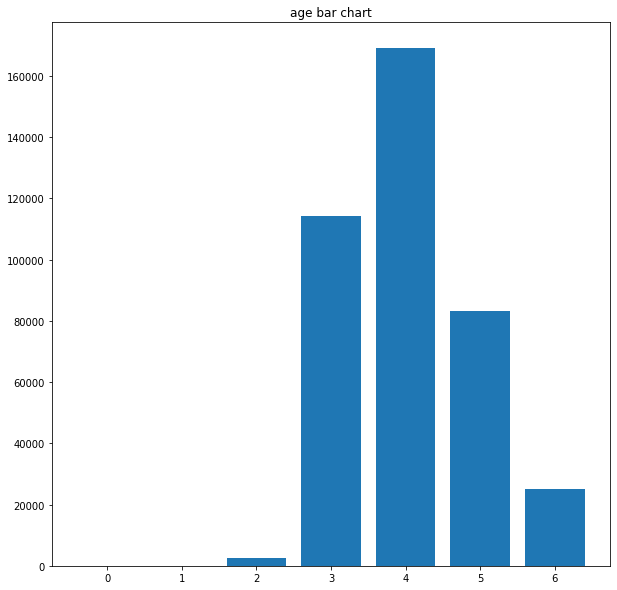

[0, 0, 2702, 114066, 169024, 83100, 24960]


In [10]:
plt.figure(figsize=(10,10))
plt.title('age bar chart')
age_cnt = [np.sum(data['demographics']['age'][data['demographics']['age'] == i]) for i in range(7)]
plt.bar(np.arange(7),age_cnt)
plt.show()
print(age_cnt)

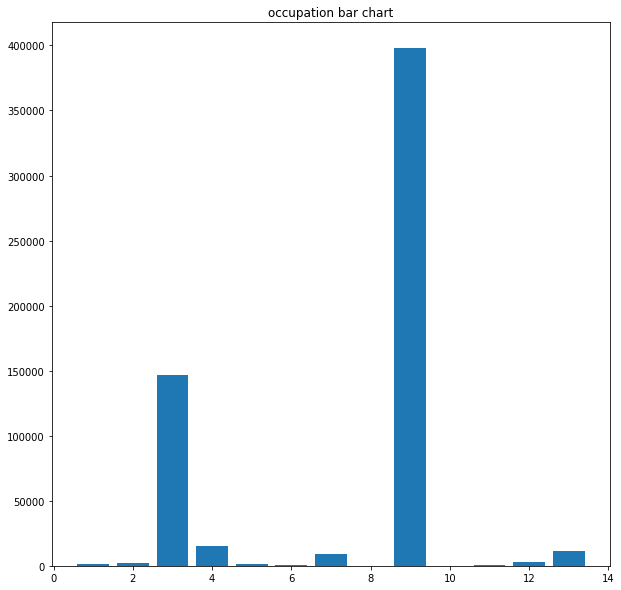

[1659.0, 1804.0, 146637.0, 15312.0, 1225.0, 942.0, 9254.0, 160.0, 397962.0, 0.0, 407.0, 3168.0, 11076.0]


In [11]:
plt.figure(figsize=(10,10))
plt.title('occupation bar chart')
age_cnt = [np.sum(data['demographics']['ocp_cd'][data['demographics']['ocp_cd'] == i]) for i in range(1,14)]
plt.bar(np.arange(1,14),age_cnt)
plt.show()
print(age_cnt)

In [12]:
print('male:', np.sum(data[kw[0]]['gender'][data[kw[0]]['gender'] == 1]))
print('female:',np.sum(data[kw[0]]['gender'][data[kw[0]]['gender'] == 2]))

male: 48299
female: 108220


### Create info by id dict 

info_by_id -> {cc_no, gender, ocp_cd, age, isTrain}

In [253]:
info_by_id = {}
#compute info_by_id
for i in range(len(data[kw[0]])):
    _id = data[kw[0]].iloc[i]['id']
    try:
        info_by_id[_id]['cc_no'] |= {data[kw[0]].iloc[i]['cc_no']}
    except:
        info_by_id[_id] = {'cc_no': {data[kw[0]].iloc[i]['cc_no']}, 
                           'gender': data[kw[0]].iloc[i]['gender'],
                           'ocp_cd': data[kw[0]].iloc[i]['ocp_cd'], 
                           'age': data[kw[0]].iloc[i]['age']
                          }

#add isTrain attribute
for i in range(len(data['train'])):
    info_by_id[data['train'].iloc[i]['id']]['isTrain'] = True
for i in range(len(data['test'])):
    info_by_id[data['test'].iloc[i]['id']]['isTrain'] = False

#sanity check
for item in info_by_id:
    if 'isTrain' not in info_by_id[item].keys():
        print(item)
        raise ValueError('isTrain not in this id')

#add income attribute
for i in range(len(data['train'])):
    info_by_id[data['train'].iloc[i]['id']]['income'] = data['train'].iloc[i]['income']
for i in range(len(data['test'])):
    info_by_id[data['test'].iloc[i]['id']]['income'] = data['test'].iloc[i]['income'] = -1

#sanity check
for item in info_by_id:
    if 'income' not in info_by_id[item].keys():
        print(item)
        raise ValueError('income not in this id')

### Add transactional data into info_by_cc

info_by_cc -> {pos_dt, cc_txn_amt}

In [249]:
info_by_cc = {}
#compute info_by_cc
for i in progressbar.progressbar(range(len(data[kw[1]]))):
    ccn = data[kw[1]].iloc[i]['cc_no']
    try:
        info_by_cc[ccn]['pos_dt'].append(data[kw[1]].iloc[i]['pos_dt'])
        info_by_cc[ccn]['cc_txn_amt'].append(data[kw[1]].iloc[i]['cc_txn_amt'])
    except:
        info_by_cc[ccn] = {
            'pos_dt': [data[kw[1]].iloc[i]['pos_dt']],
            'cc_txn_amt': [data[kw[1]].iloc[i]['cc_txn_amt']]
        }

100% (999113 of 999113) |################| Elapsed Time: 0:06:32 Time:  0:06:32


In [262]:
info_by_cc[87633].keys()

dict_keys(['pos_dt', 'cc_txn_amt'])

### Add kplus transactional data into info_by_data

info_by_id -> {cc_no, gender, ocp_cd, age, isTrain, sunday, kp_txn_count, kp_txn_amt}

In [254]:
for i in progressbar.progressbar(range(len(data[kw[2]]))):
    _id = data[kw[2]].iloc[i]['id']
    try:
        info_by_id[_id]['sunday'].append(data[kw[2]].iloc[i]['sunday'])
        info_by_id[_id]['kp_txn_count'].append(data[kw[2]].iloc[i]['kp_txn_count'])
        info_by_id[_id]['kp_txn_amt'].append(data[kw[2]].iloc[i]['kp_txn_amt'])
    except:
        info_by_id[_id]['sunday'] = [data[kw[2]].iloc[i]['sunday']]
        info_by_id[_id]['kp_txn_count'] = [data[kw[2]].iloc[i]['kp_txn_count']]
        info_by_id[_id]['kp_txn_amt'] = [data[kw[2]].iloc[i]['kp_txn_amt']]

100% (889548 of 889548) |################| Elapsed Time: 0:07:39 Time:  0:07:39


In [258]:
info_by_id[1].keys()

dict_keys(['cc_no', 'gender', 'ocp_cd', 'age', 'isTrain', 'income', 'sunday', 'kp_txn_count', 'kp_txn_amt'])

### Save both dict to pickle / load both dict back

In [4]:
import pickle

#pickle save dictionary to files

# with open('info_by_id.pickle', 'wb') as handle:
#     pickle.dump(info_by_id, handle, protocol=pickle.HIGHEST_PROTOCOL)
# with open('info_by_cc.pickle', 'wb') as handle:
#     pickle.dump(info_by_cc, handle, protocol=pickle.HIGHEST_PROTOCOL)

#pickle load save dict

# with open('info_by_id.pickle', 'rb') as handle:
#     info_by_id = pickle.load(handle)
# with open('info_by_cc.pickle', 'rb') as handle:
#     info_by_cc = pickle.load(handle)

### Categorize income data by gender & occupation

In [157]:
# categorize income by gender (inc[0] -> male income, inc[1] -> female income)
inc_by_gender = [[], []]
for _id in info_by_id:
    if info_by_id[_id]['income'] != -1:
        inc_by_gender[int(info_by_id[_id]['gender']-1)].append(info_by_id[_id]['income'])

# categorize income by occupation (inc[0] -> ocp_1 income, inc[1] -> ocp_2 income, ...)
inc_by_ocp = []
for i in range(13):
    inc_by_ocp.append([])
for _id in info_by_id:
    if np.isnan(info_by_id[_id]['ocp_cd']):
        info_by_id[_id]['ocp_cd'] = -1 #set NaN to -1 instead
    if info_by_id[_id]['income'] != -1:
        inc_by_ocp[int(info_by_id[_id]['ocp_cd']-1)].append(info_by_id[_id]['income'])

In [283]:
info_by_cc[123]

{'pos_dt': ['2018-03-02',
  '2018-04-27',
  '2018-02-03',
  '2018-05-19',
  '2018-05-27',
  '2018-01-26',
  '2018-03-18',
  '2018-01-28',
  '2018-05-18',
  '2018-03-16',
  '2018-01-29',
  '2018-04-04',
  '2018-02-27',
  '2018-04-12',
  '2018-06-25'],
 'cc_txn_amt': [2000,
  300,
  2500,
  1100,
  2000,
  7000,
  5400,
  3000,
  800,
  2000,
  800,
  600,
  2000,
  700,
  2000]}

In [342]:
#calculate mapping from ccn -> id
ccn_to_id = {}
for _id in info_by_id:
    for ccn in info_by_id[_id]['cc_no']:
        ccn_to_id[ccn] = _id

### Timeline view of credit card transaction

In [344]:
def show_timeline(ccn, figsize=(25,10)):
    #ref: https://matplotlib.org/3.1.1/gallery/lines_bars_and_markers/timeline.html
    
    names = info_by_cc[ccn]['cc_txn_amt']
    dates = info_by_cc[ccn]['pos_dt']
    _id = ccn_to_id[ccn]
    income = info_by_id[_id]['income']
    gender = info_by_id[_id]['gender']
    ocp = info_by_id[_id]['ocp_cd']
    if gender == 1:
        gender = 'Male'
    else:
        gender = 'Female'
    # Convert date strings (e.g. 2014-10-18) to datetime
    dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
    levels = np.array(names)
    levels[levels > 20000] = 20000
    # Create figure and plot a stem plot with the date
    fig, ax = plt.subplots(figsize=figsize, constrained_layout=True)
    ax.set(title="Timeline of credit card id:{} income:{} gender:{} ocp_cd:{} ".format(ccn,income,gender,ocp))

    markerline, stemline, baseline = ax.stem(dates, levels,
                                             linefmt="C3-", basefmt="k-",
                                             use_line_collection=True)

    plt.setp(markerline, mec="k", mfc="w", zorder=3)

    # Shift the markers to the baseline by replacing the y-data by zeros.
    markerline.set_ydata(np.zeros(len(dates)))

    # annotate lines
    vert = np.array(['top', 'bottom'])[(levels > 0).astype(int)]
    for d, l, r, va in zip(dates, levels, names, vert):
        plt.setp(ax.annotate(r, xy=(d, l), xytext=(-3, np.sign(l)*3),
                    textcoords="offset points", va=va, ha="right"), rotation=50, ha="center")


    # format xaxis with 4 month intervals
    ax.get_xaxis().set_major_locator(mdates.MonthLocator(interval=1))
    ax.get_xaxis().set_major_formatter(mdates.DateFormatter("%b %Y"))
    plt.setp(ax.get_xticklabels(), rotation=30, ha="right")

    # remove y axis and spines
    ax.get_yaxis().set_visible(False)
    for spine in ["left", "top", "right"]:
        ax.spines[spine].set_visible(False)

    ax.margins(y=0.1)
    plt.show()

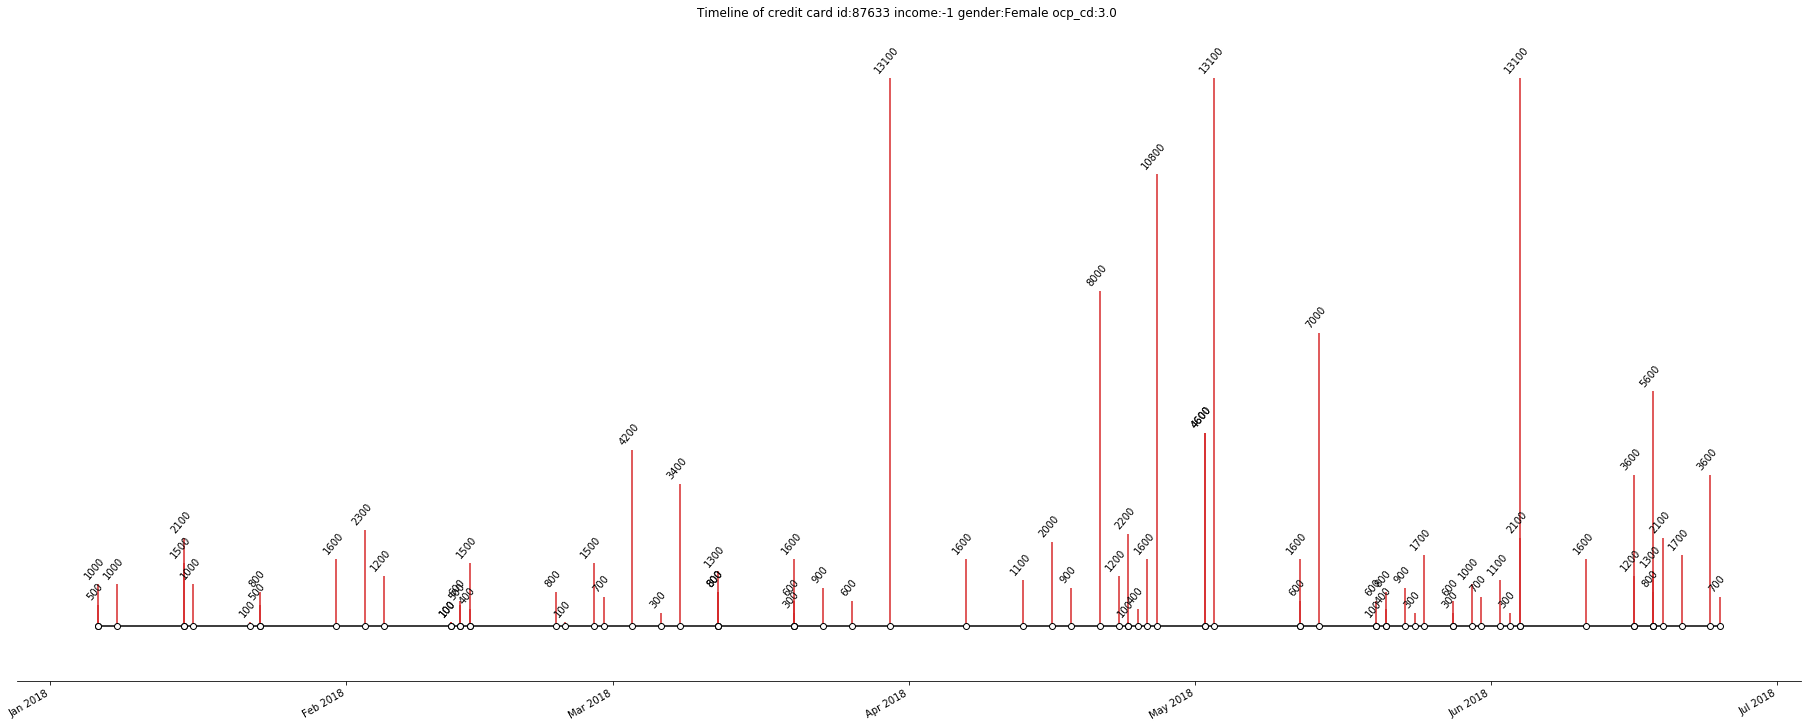

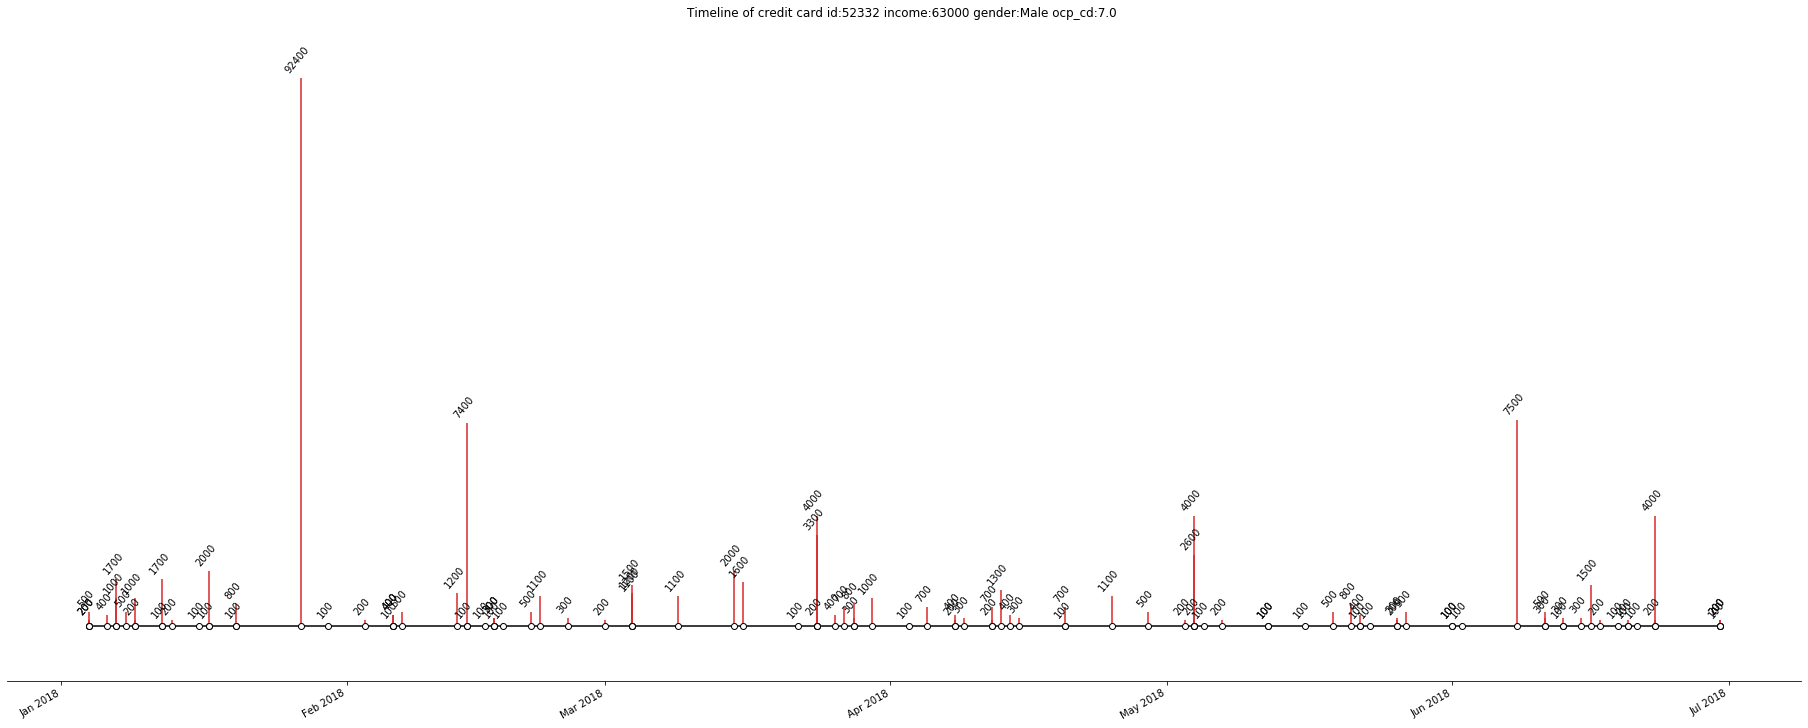

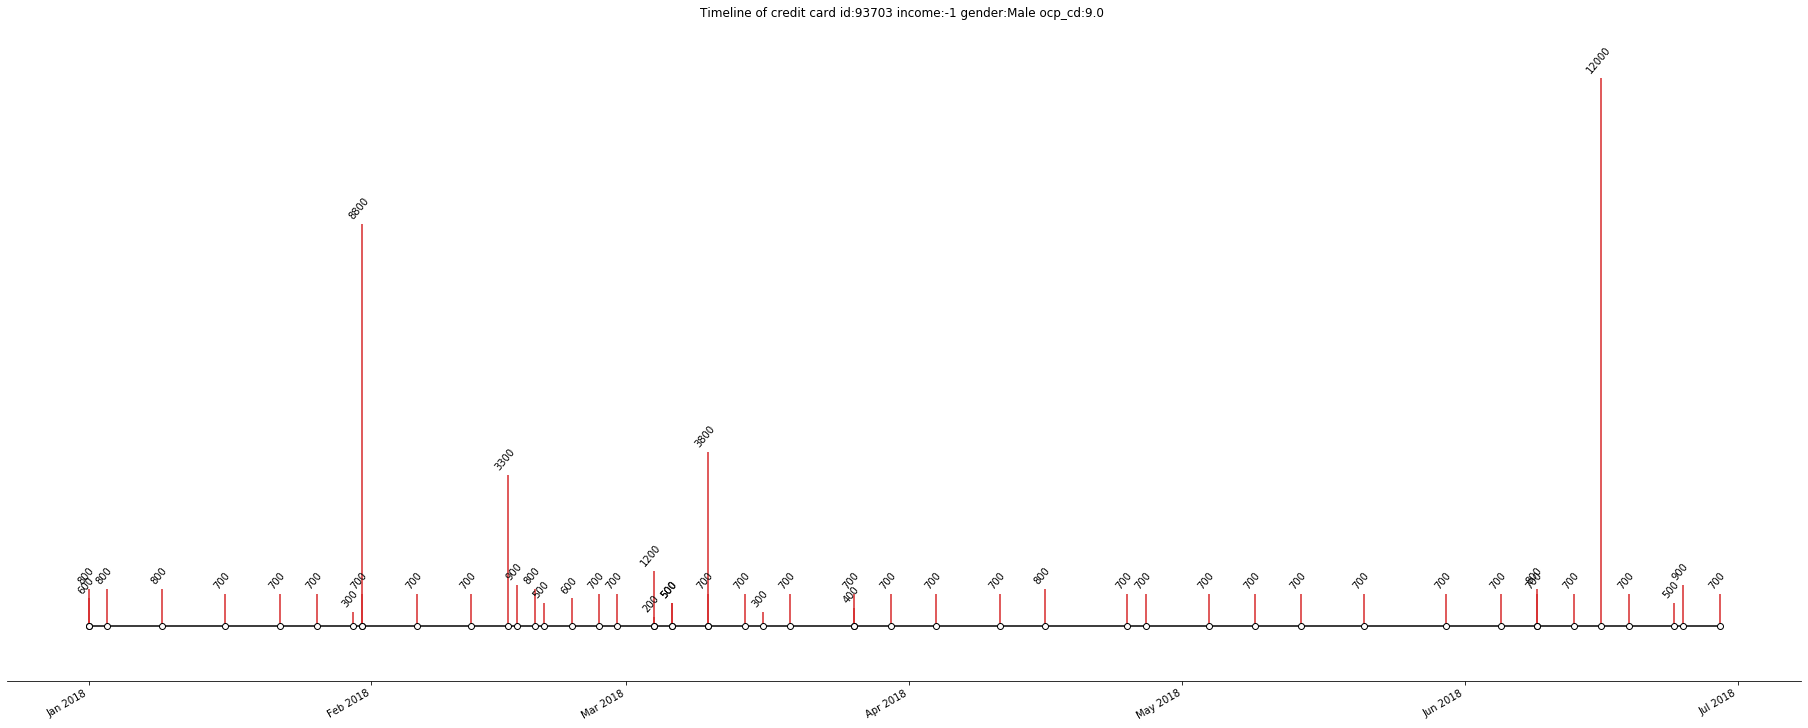

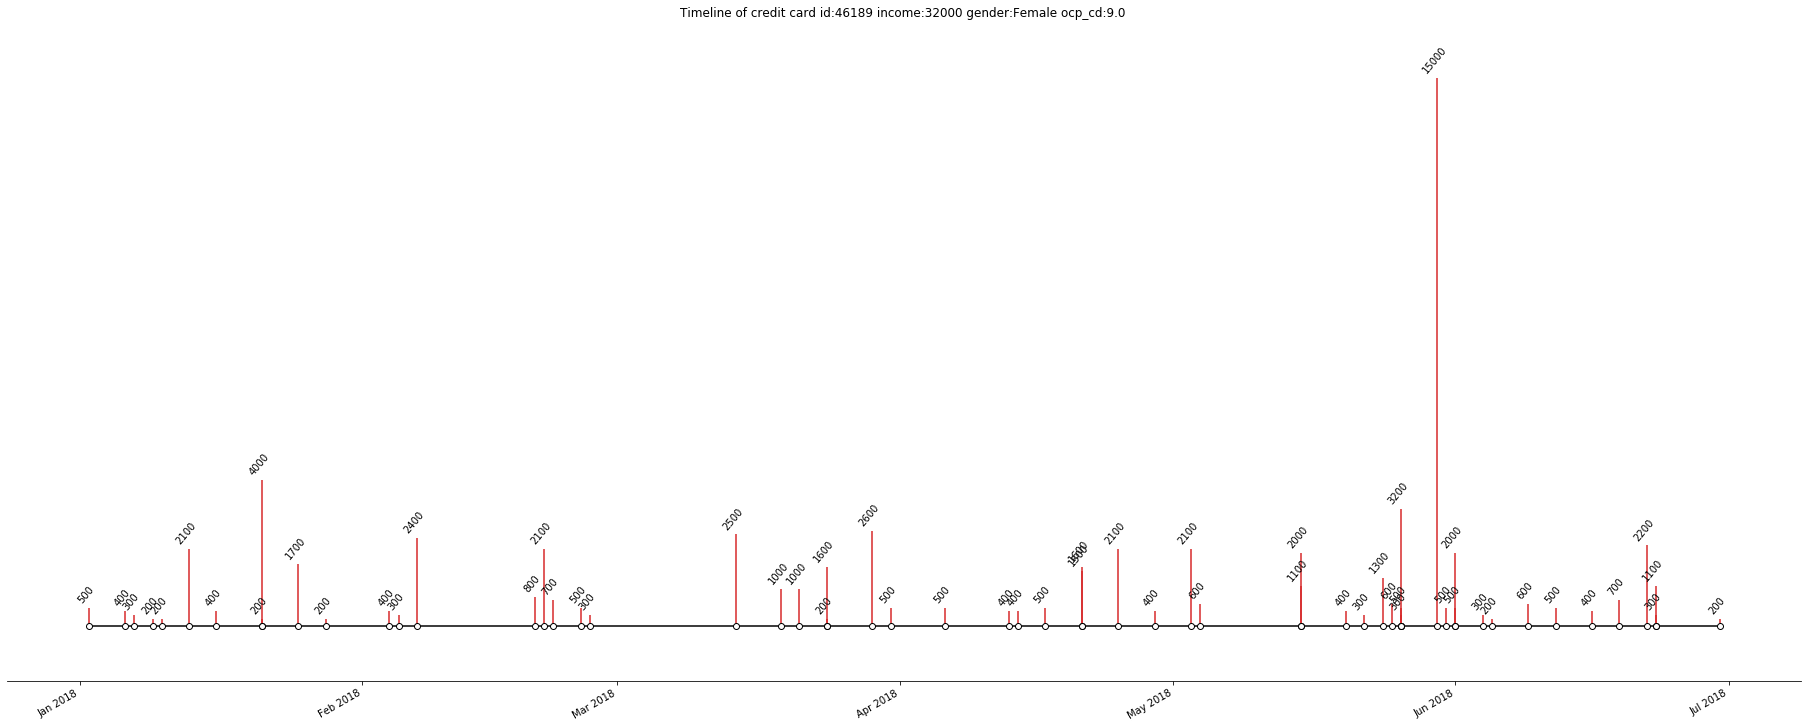

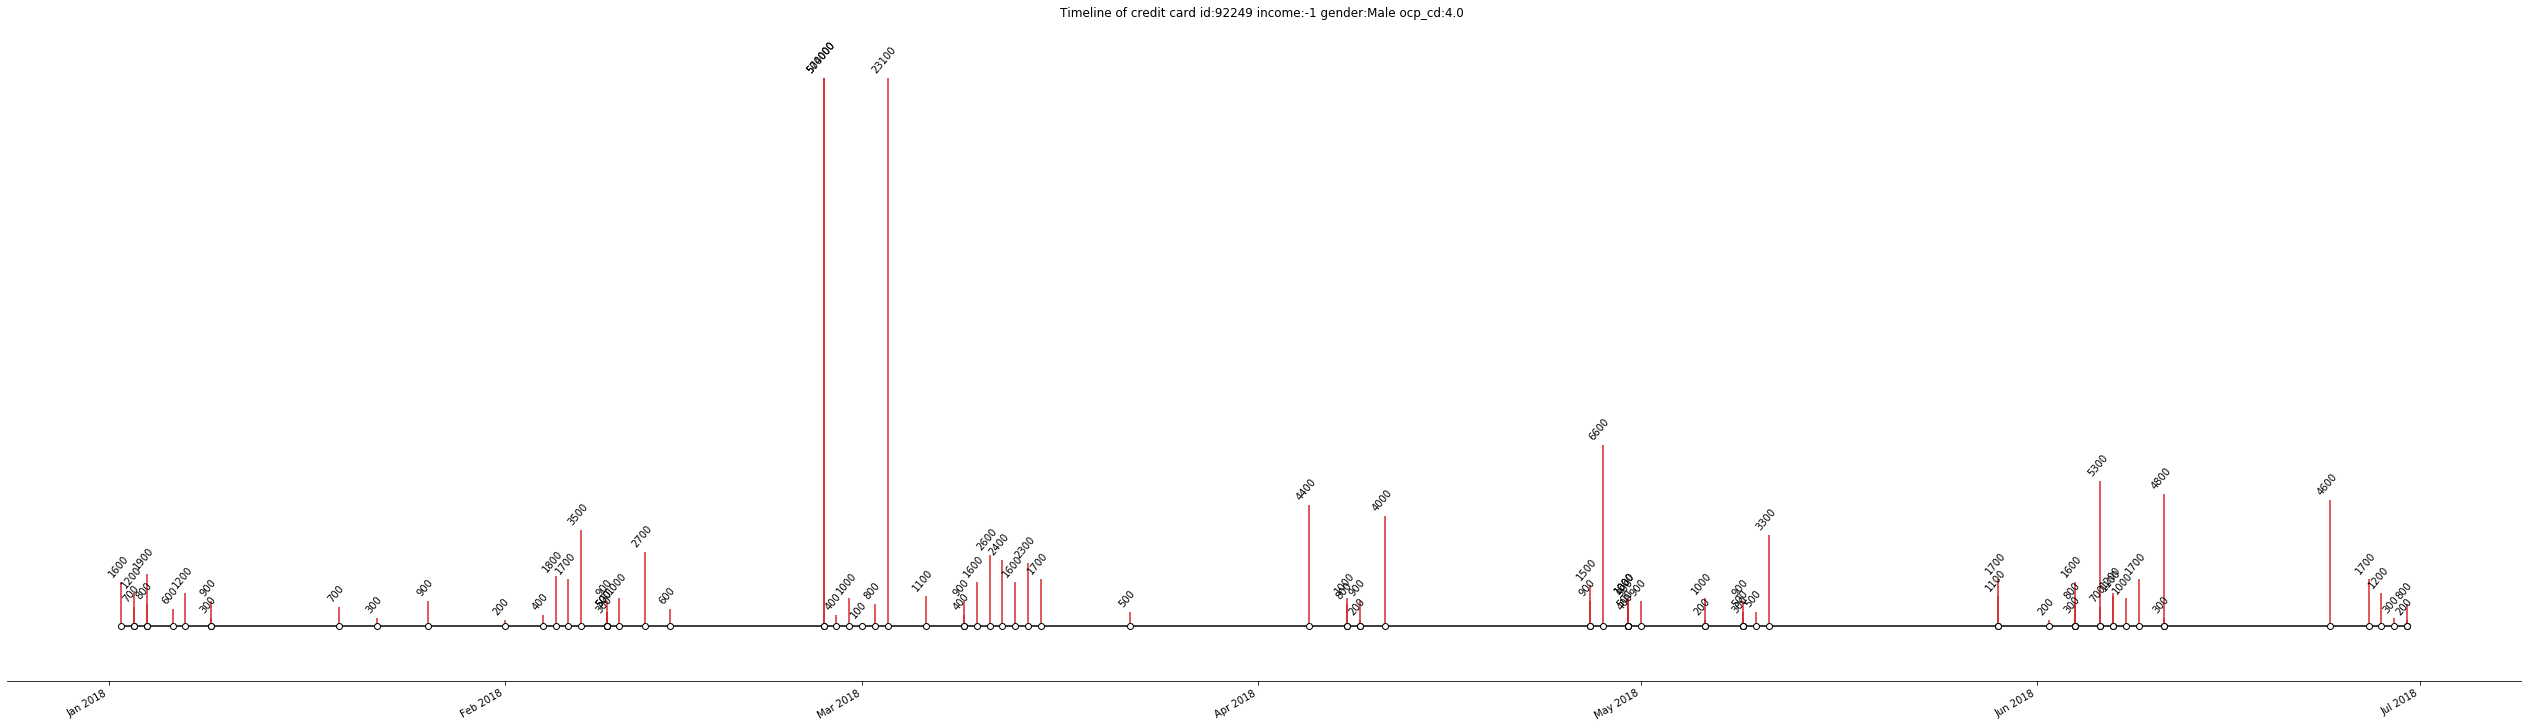

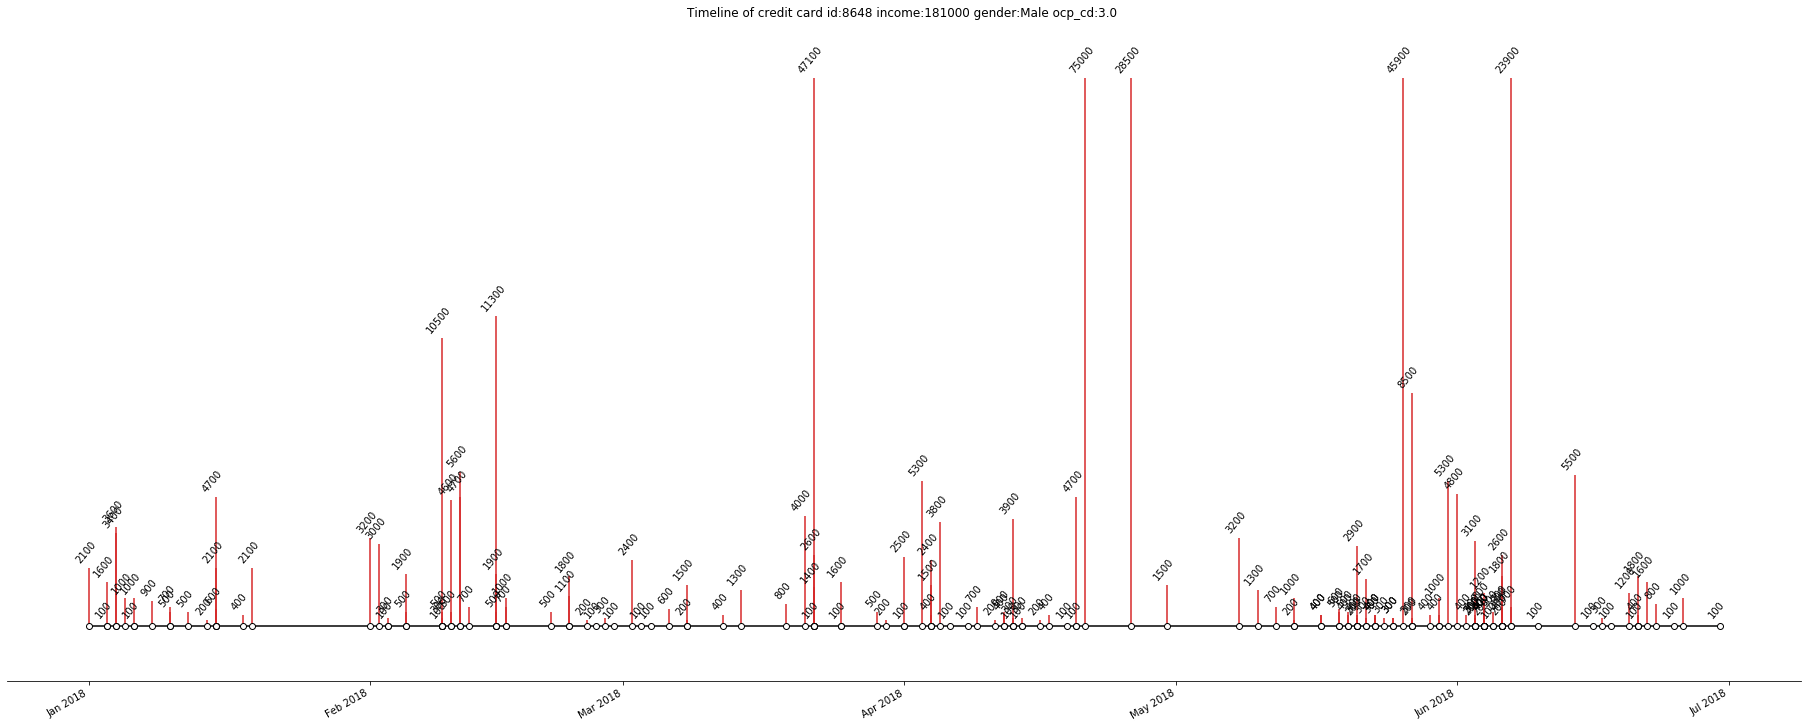

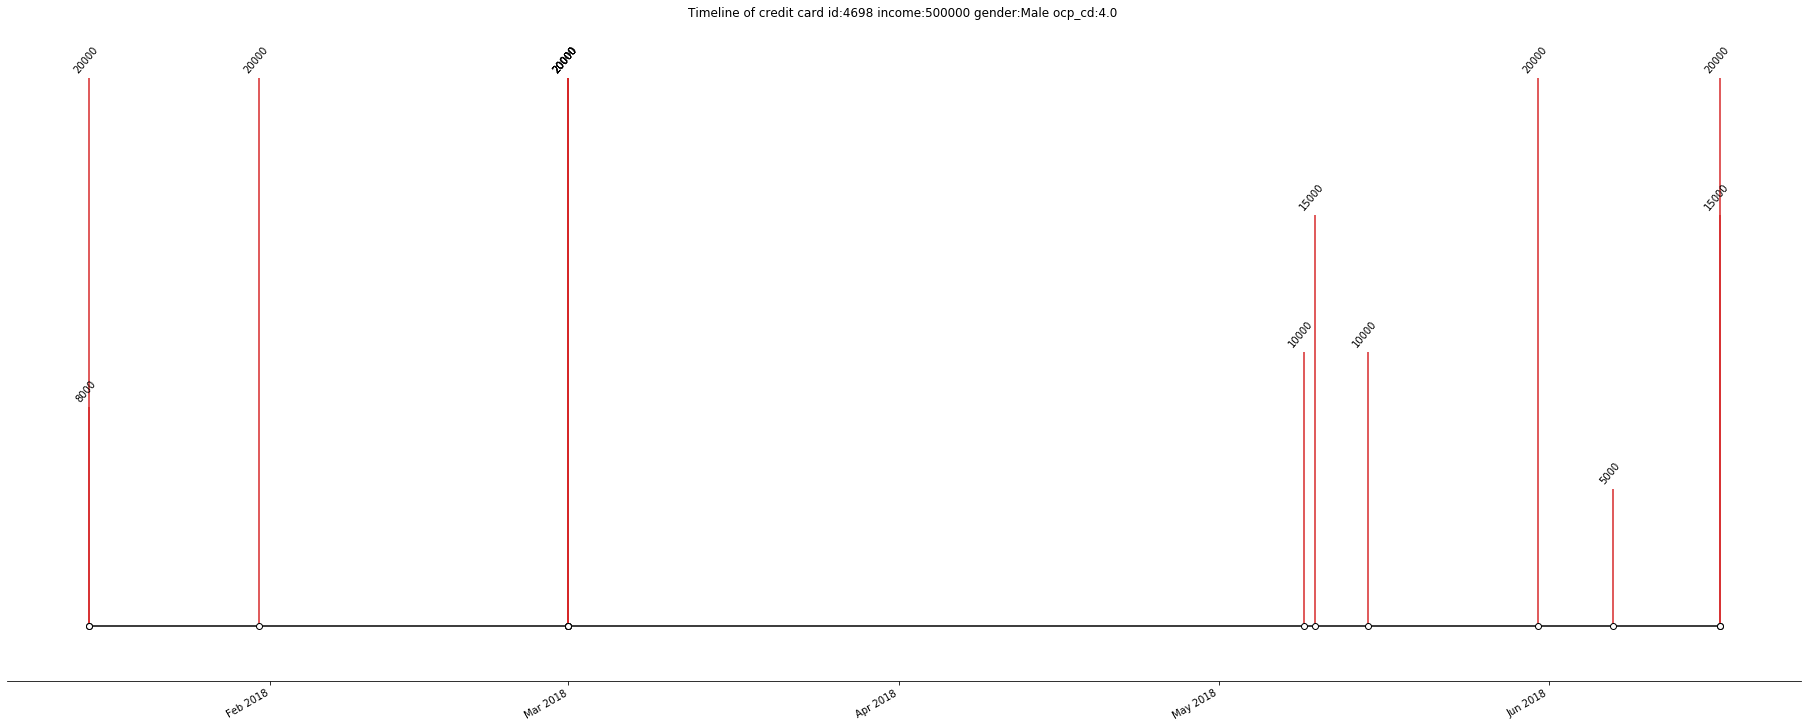

In [345]:
show_timeline(87633)
show_timeline(52332)
show_timeline(93703)
show_timeline(46189)
show_timeline(92249,figsize=(35,10))
show_timeline(8648)
show_timeline(4698)

In [350]:
info_by_id[11001]

{'cc_no': {11661.0, 18086.0},
 'gender': 2.0,
 'ocp_cd': 9.0,
 'age': 5.0,
 'isTrain': True,
 'income': 208000,
 'sunday': ['2018-06-10',
  '2018-02-18',
  '2018-06-17',
  '2018-04-01',
  '2018-04-15',
  '2018-03-25',
  '2018-04-08',
  '2018-04-29',
  '2018-02-25',
  '2018-06-24',
  '2018-05-06',
  '2018-06-03',
  '2018-03-04',
  '2018-04-22',
  '2018-02-11',
  '2018-05-27',
  '2018-03-11',
  '2018-01-28',
  '2018-05-13',
  '2018-01-21',
  '2018-02-04',
  '2018-01-14',
  '2018-05-20',
  '2018-03-18'],
 'kp_txn_count': [4,
  2,
  5,
  6,
  1,
  3,
  3,
  5,
  3,
  5,
  6,
  7,
  6,
  3,
  2,
  9,
  3,
  4,
  4,
  4,
  4,
  7,
  9,
  1],
 'kp_txn_amt': [121200,
  9600,
  66300,
  33200,
  4600,
  7900,
  25700,
  67600,
  3000,
  84500,
  47100,
  195500,
  35500,
  6400,
  4000,
  26900,
  60800,
  33000,
  12400,
  12600,
  17100,
  13000,
  144500,
  6000]}

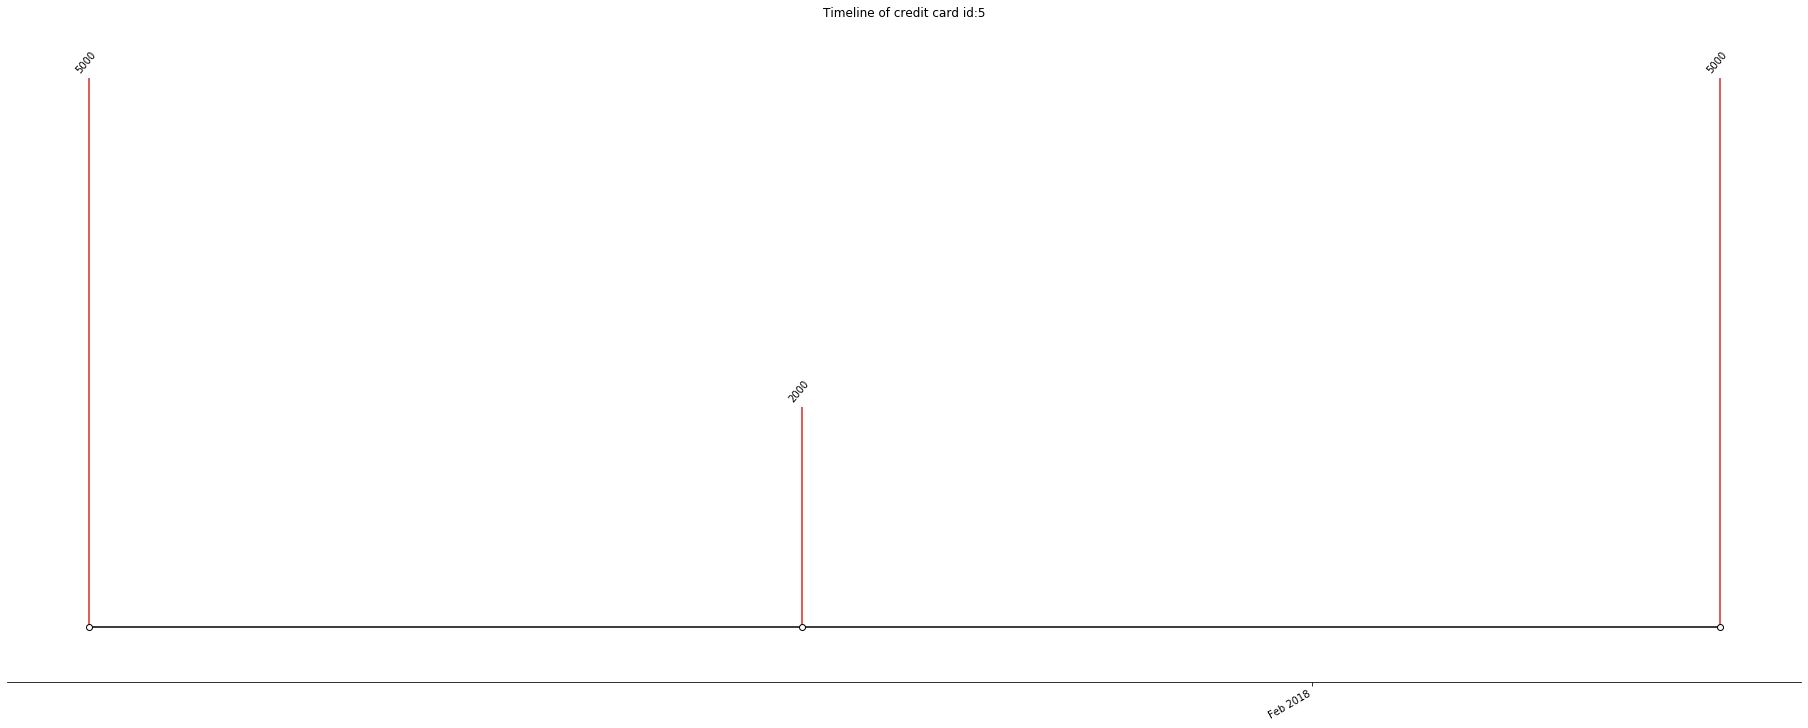

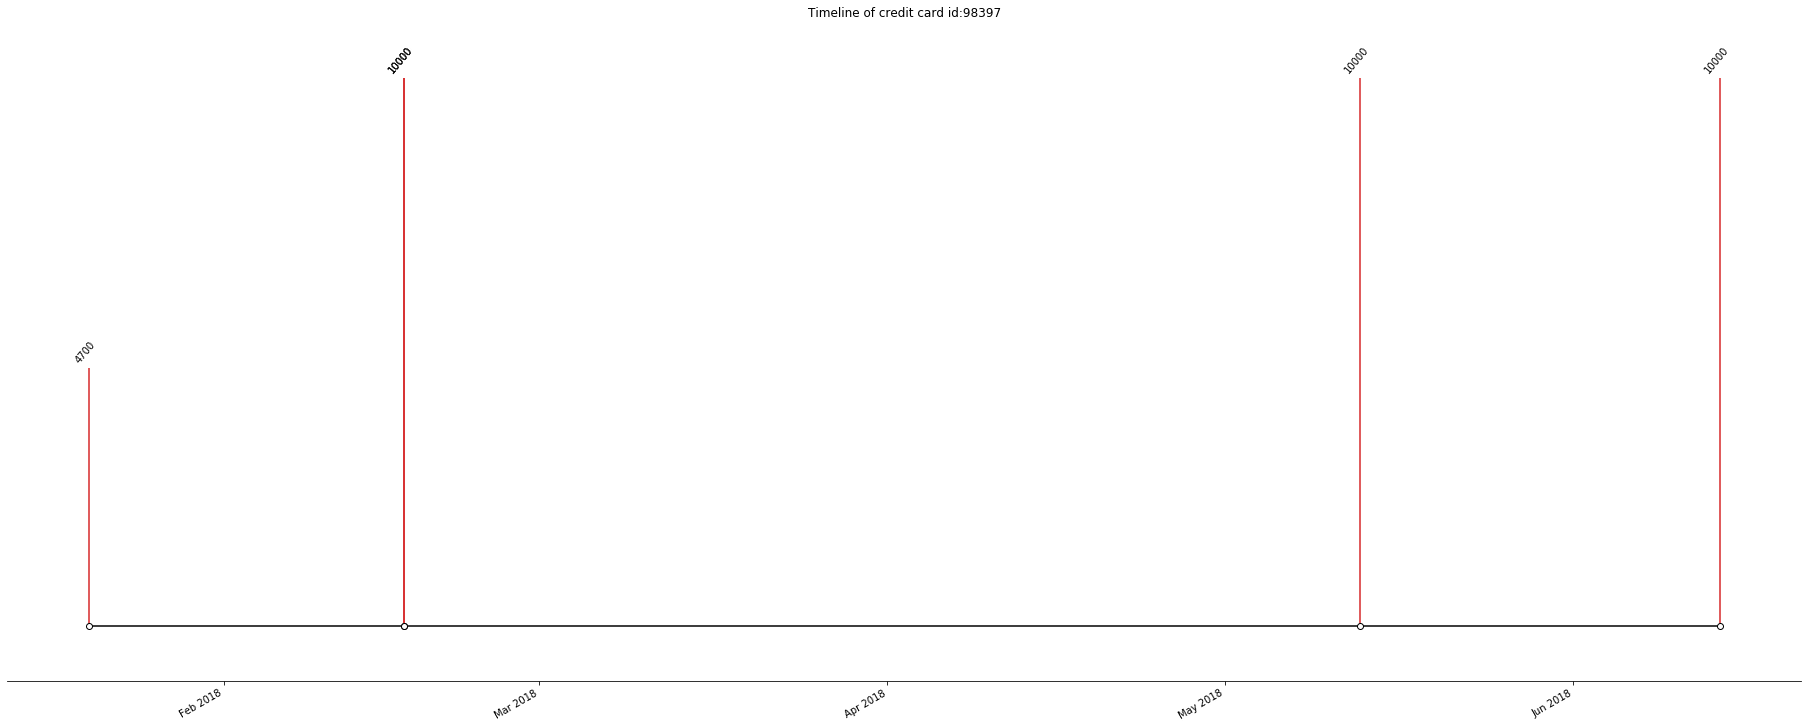

In [336]:
show_timeline(5)
show_timeline(98397)

6.0


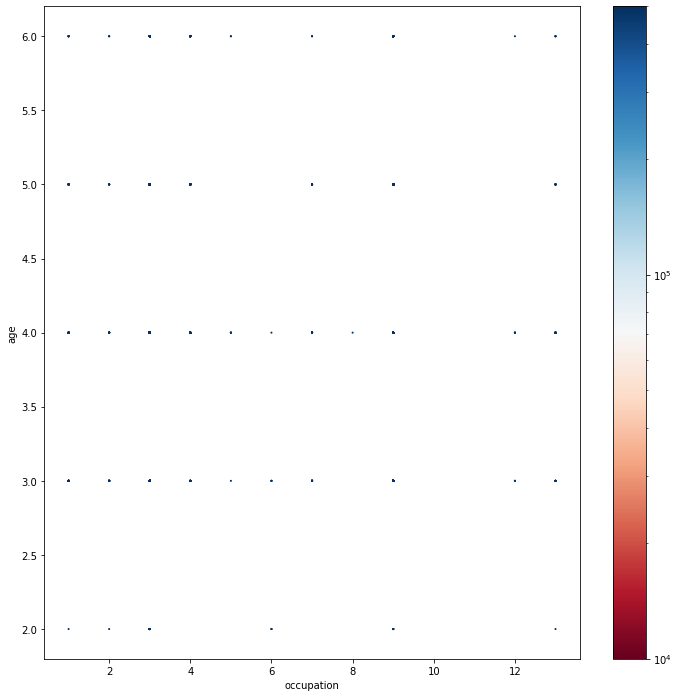

In [218]:
import matplotlib.colors as cs
fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111)
cnt = 0
x = []
y = []
z = []

for _id in info_by_id:
    cnt += 1
    if cnt > 5000:
        break
    if info_by_id[_id]['income'] != -1: #plot only valid income
        x.append(info_by_id[_id]['ocp_cd'])
        y.append(info_by_id[_id]['age'])
        z.append(info_by_id[_id]['income'])
z = np.array(z)
print(max(y))
# colors = cm.hsv(np.array(z)/max(z))
# z[z > 100000] = 100000 #set all 
colors = cm.RdBu(z)
colmap = cm.ScalarMappable(cmap=cm.RdBu, norm=cs.LogNorm(vmin=z.min(), vmax=z.max()))
colmap.set_array(z)
yg = ax.scatter(x, y , c=colors, marker='o', s=1)
cb = fig.colorbar(colmap)

ax.set_xlabel('occupation')
ax.set_ylabel('age')
plt.show()

/Users/daidew/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: UserWarning: Attempting to set identical bottom == top == 1 results in singular transformations; automatically expanding.
  # Remove the CWD from sys.path while we load stuff.


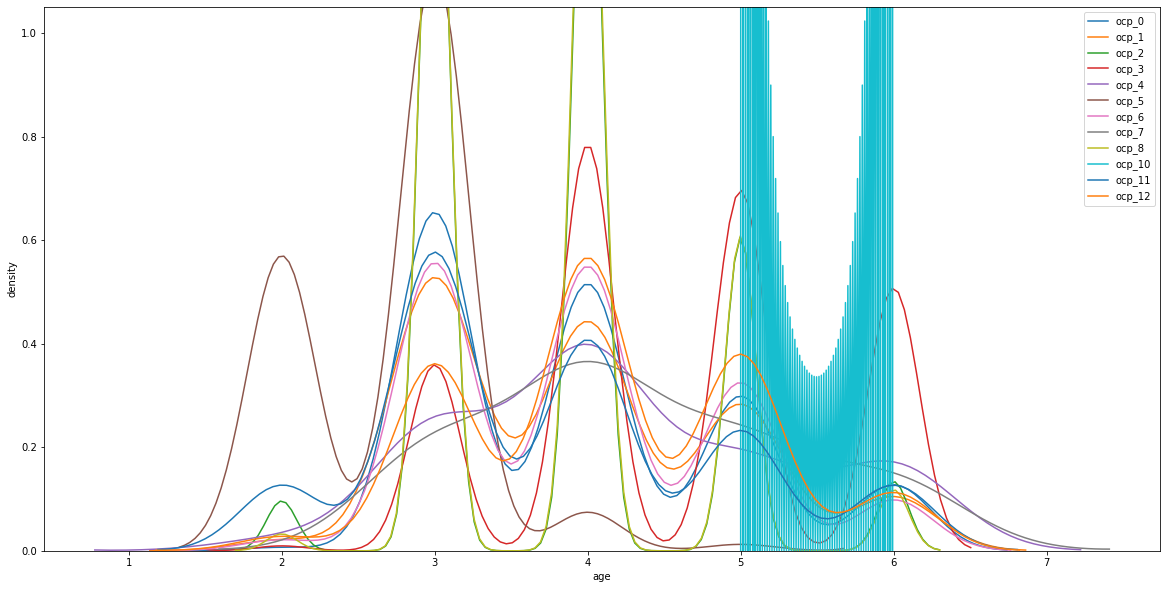

In [238]:
age_by_ocp = []
for i in range(13):
    age_by_ocp.append([])
for _id in info_by_id:
    if not np.isnan(info_by_id[_id]['ocp_cd']):
        age_by_ocp[int(info_by_id[_id]['ocp_cd']-1)].append(info_by_id[_id]['age'])
plt.figure(figsize=(20,10))
plt.xlabel('age')
plt.ylabel('density')
plt.ylim(1)
for i in range(13):
    sns.kdeplot(age_by_ocp[i], label='ocp_{}'.format(i))

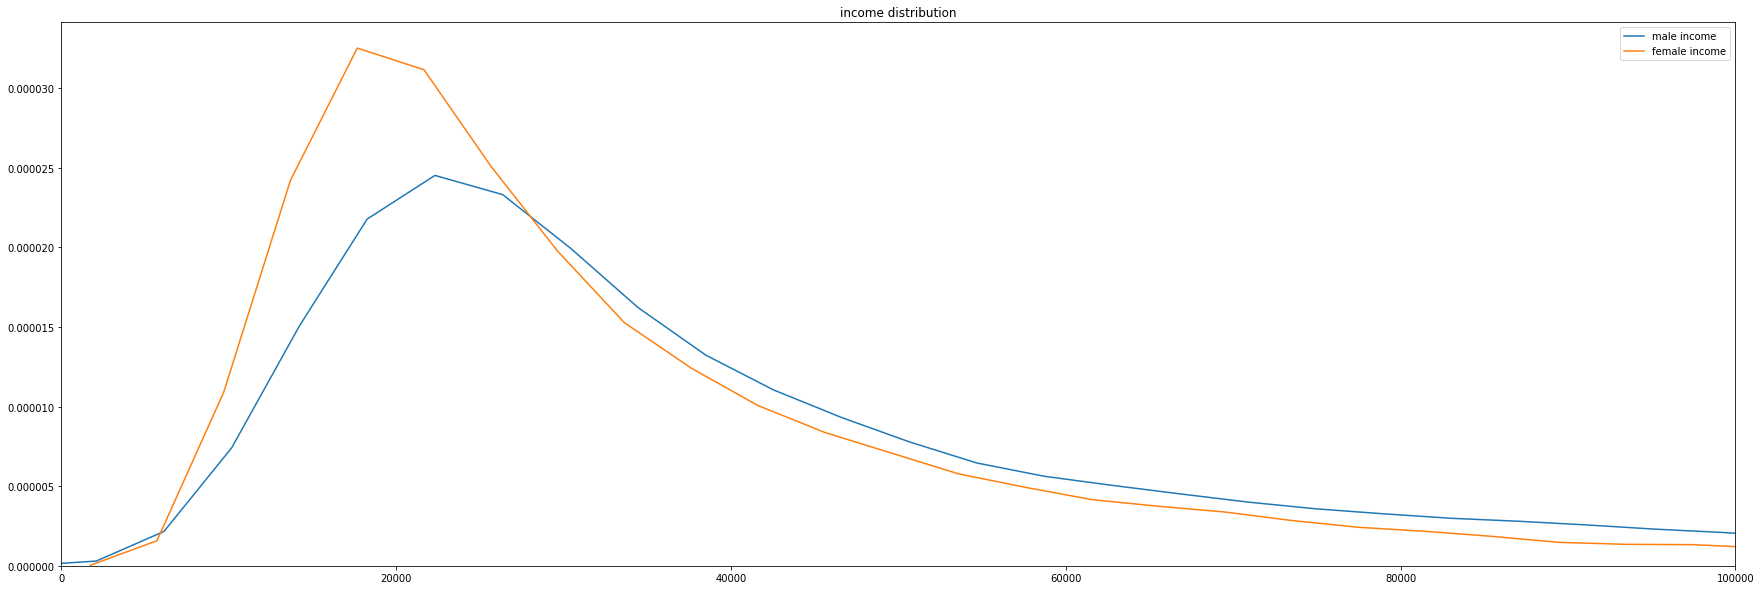

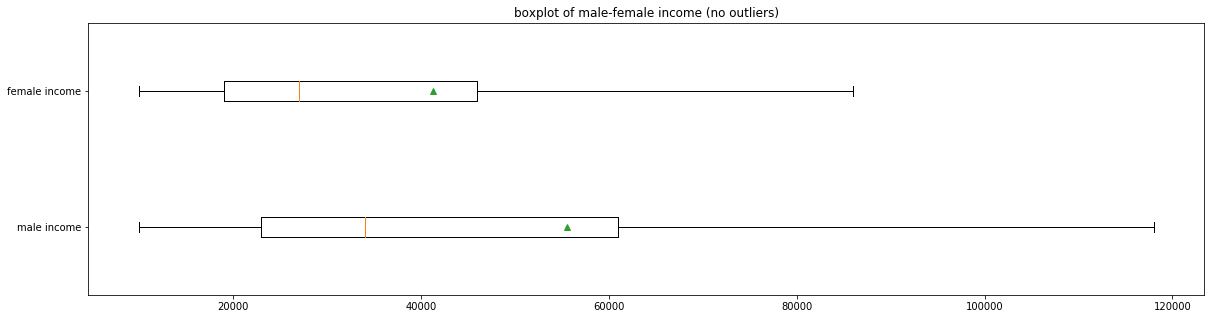

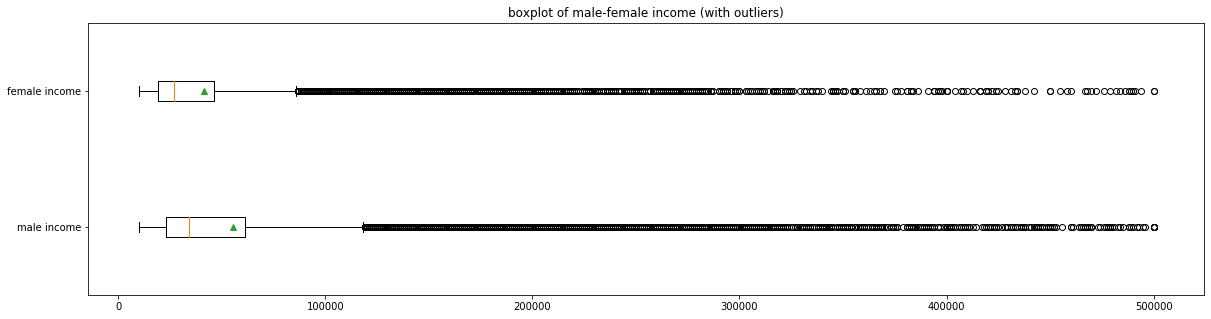

In [161]:
#plot distribution & boxplot of each gender income

fig_dist, ax_dist = plt.subplots(figsize=(30, 10))
ax_dist.set_title('income distribution')
sns.kdeplot(inc_by_gender[0], label='male income')
sns.kdeplot(inc_by_gender[1], label='female income')
ax_dist.set_xlim(0,100000)

#green dot are mean
fig, ax = plt.subplots(figsize=(20, 5))
ax.set_title('boxplot of male-female income (no outliers)')
_ = plt.boxplot(inc_by_gender,vert=False,showfliers=False,showmeans=True,labels=['male income', 'female income'])

fig2, ax2 = plt.subplots(figsize=(20, 5))
ax2.set_title('boxplot of male-female income (with outliers)')
_ = plt.boxplot(inc_by_gender,vert=False,showfliers=True,showmeans=True,labels=['male income', 'female income'])

plt.show()

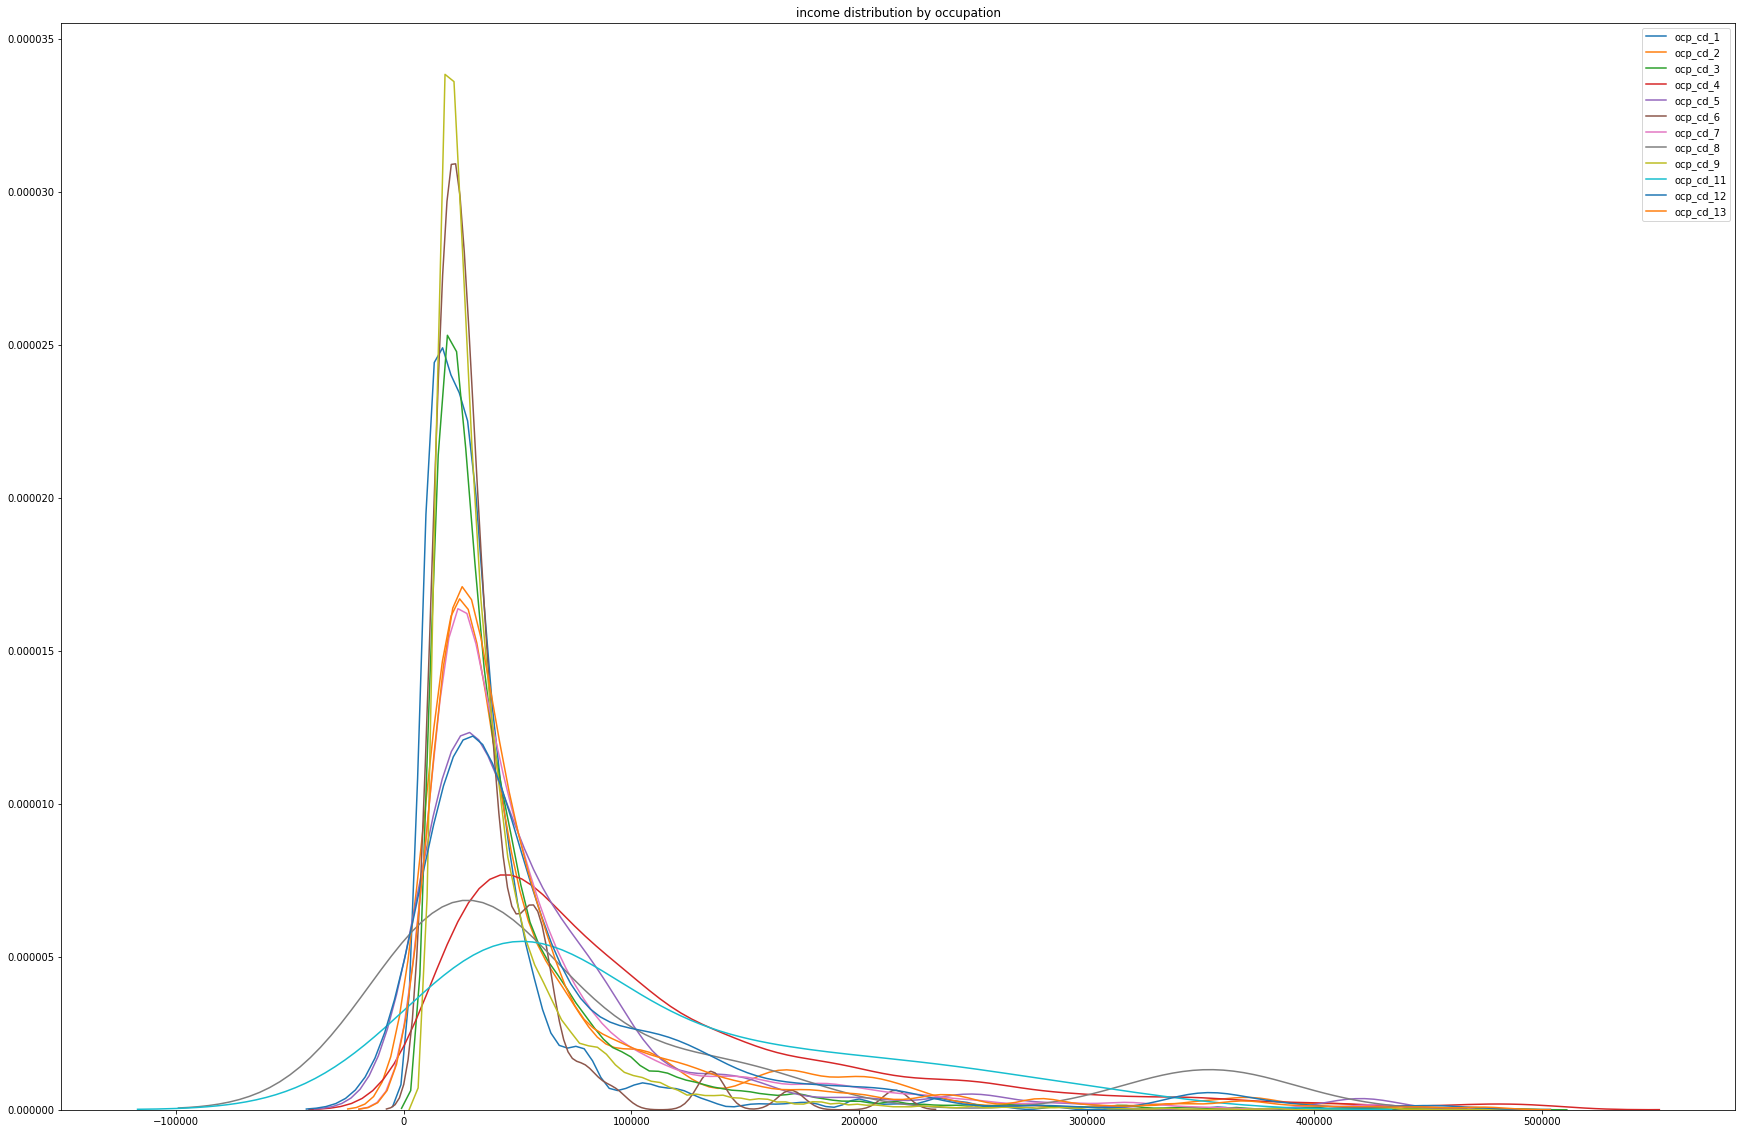

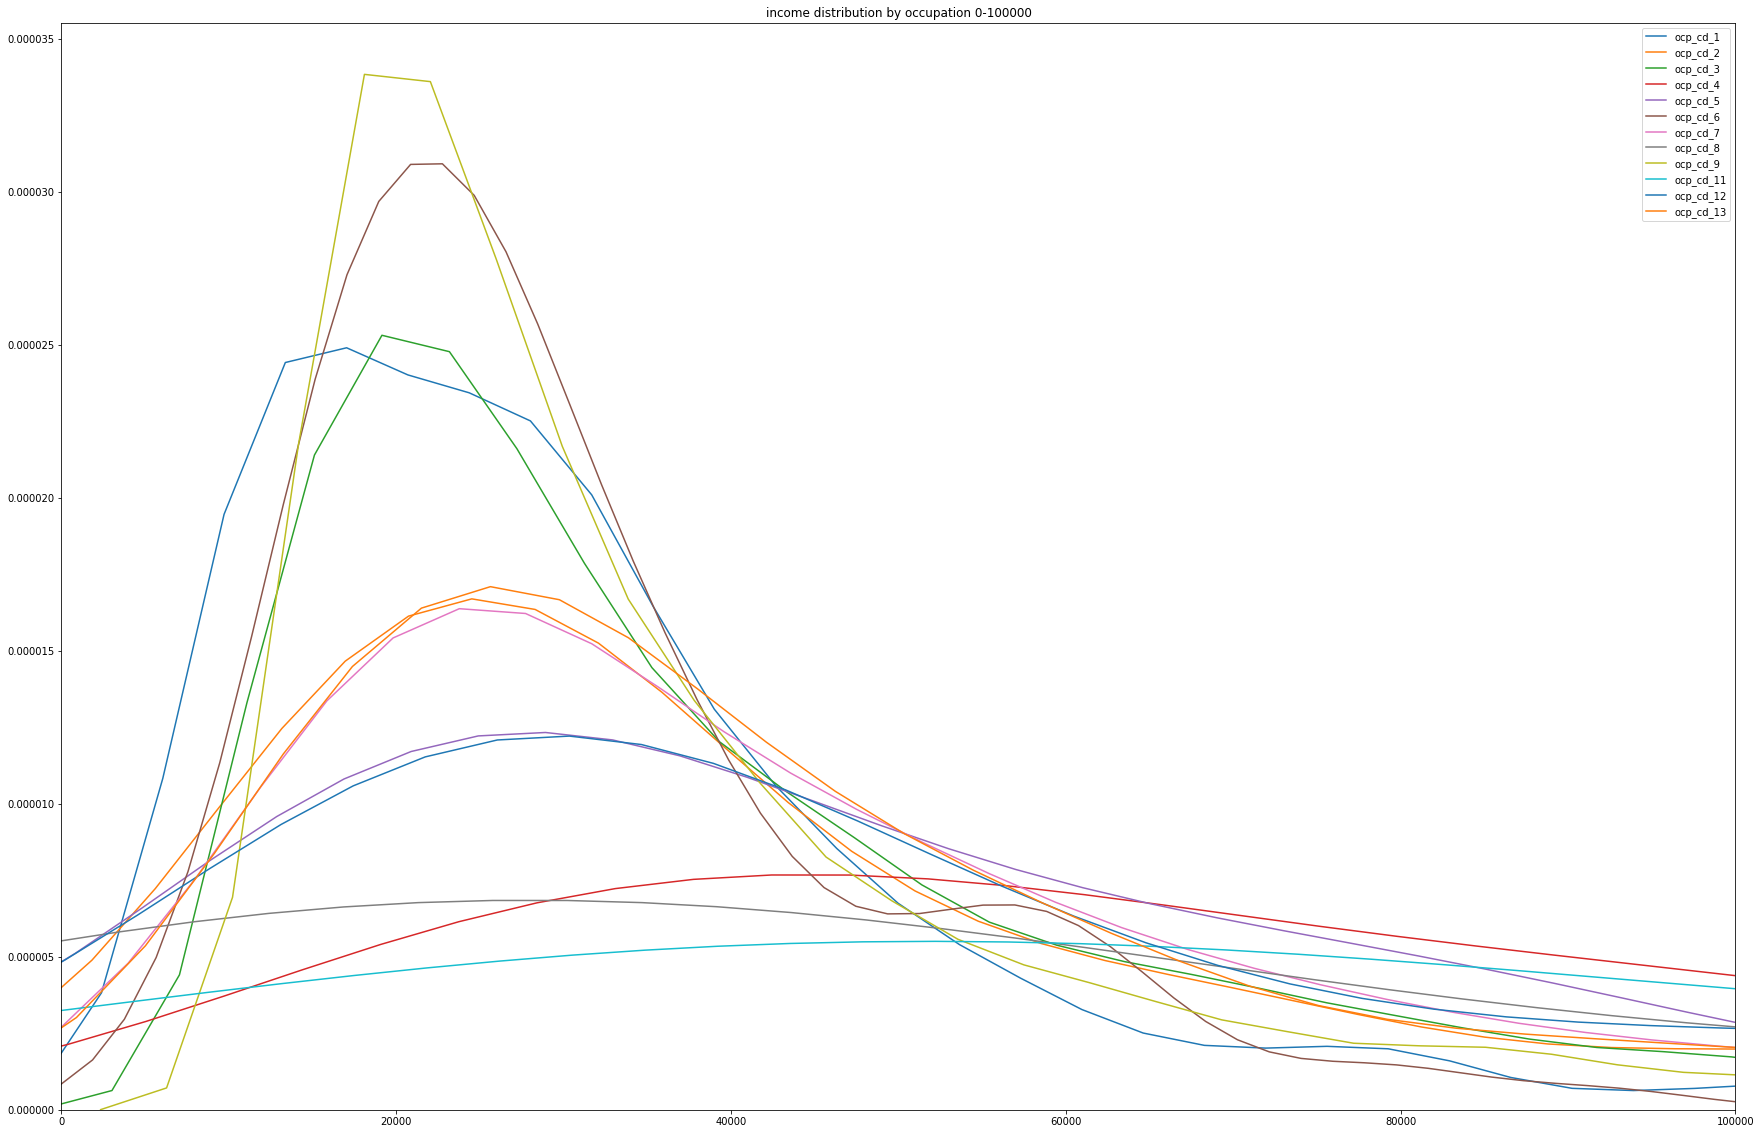

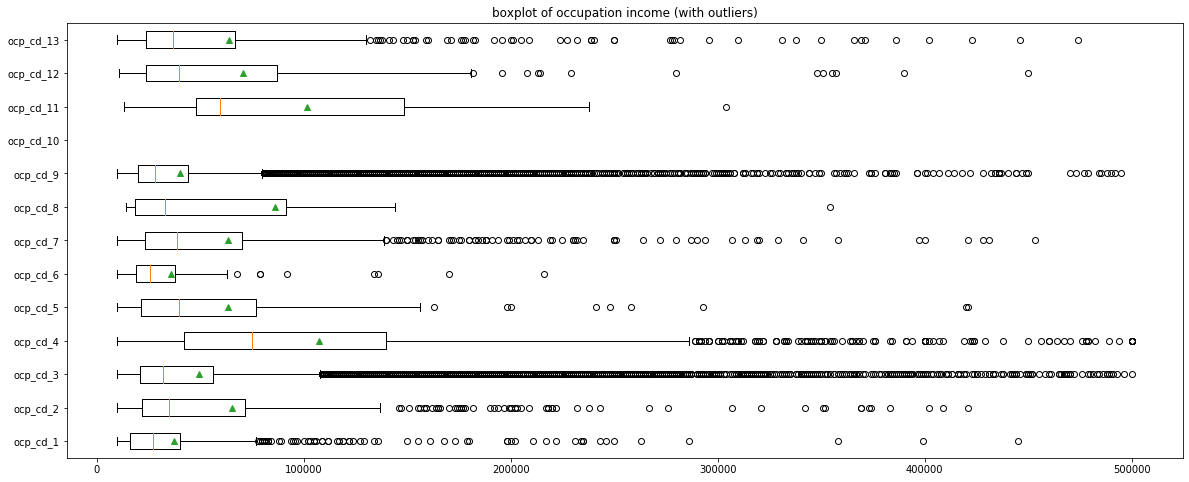

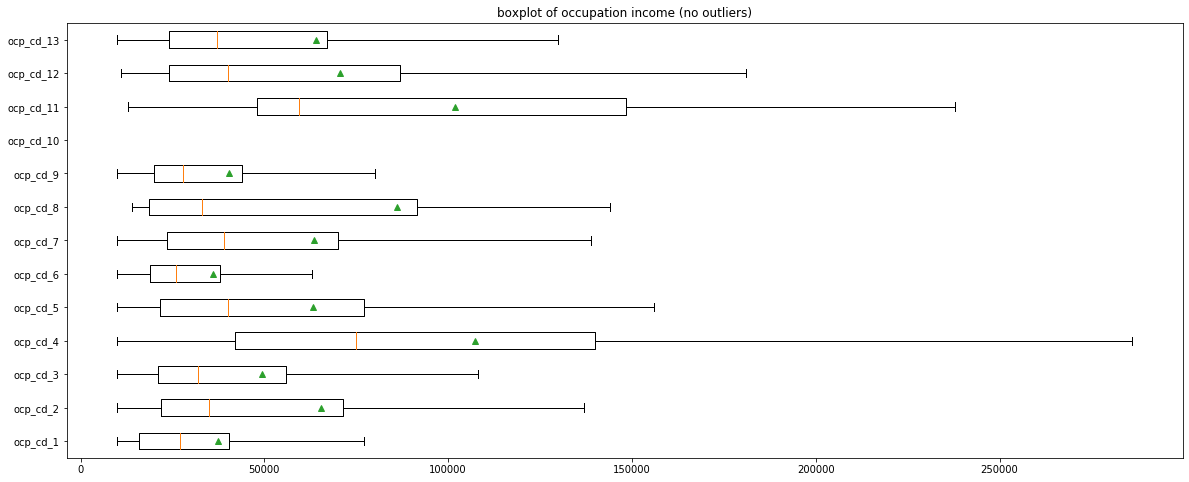

In [160]:
fig_dist, ax_dist = plt.subplots(figsize=(30, 20))
ax_dist.set_title('income distribution by occupation')
for i in range(13):
    sns.kdeplot(inc_by_ocp[i], label='ocp_cd_{}'.format(i+1))
# ax_dist.set_xlim(0,100000)

fig_dist2, ax_dist2 = plt.subplots(figsize=(30, 20))
ax_dist2.set_title('income distribution by occupation 0-100000')
for i in range(13):
    sns.kdeplot(inc_by_ocp[i], label='ocp_cd_{}'.format(i+1))
ax_dist2.set_xlim(0,100000)


fig3, ax3 = plt.subplots(figsize=(20, 8))
ax3.set_title('boxplot of occupation income (with outliers)')
_ = plt.boxplot(inc_by_ocp,vert=False,showfliers=True,showmeans=True,labels=['ocp_cd_{}'.format(i) for i in range(1,14)])

fig4, ax4 = plt.subplots(figsize=(20, 8))
ax4.set_title('boxplot of occupation income (no outliers)')
_ = plt.boxplot(inc_by_ocp,vert=False,showfliers=False,showmeans=True,labels=['ocp_cd_{}'.format(i) for i in range(1,14)])

plt.show()

In [356]:
inc_by_age = []
for i in range(6):
    inc_by_age.append([])
for _id in info_by_id:
    try:
        inc_by_age[int(info_by_id[_id]['age']-1)].append(info_by_id[_id]['income'])
    except:
        inc_by_age[int(info_by_id[_id]['age']-1)] = info_by_id[_id]['income']

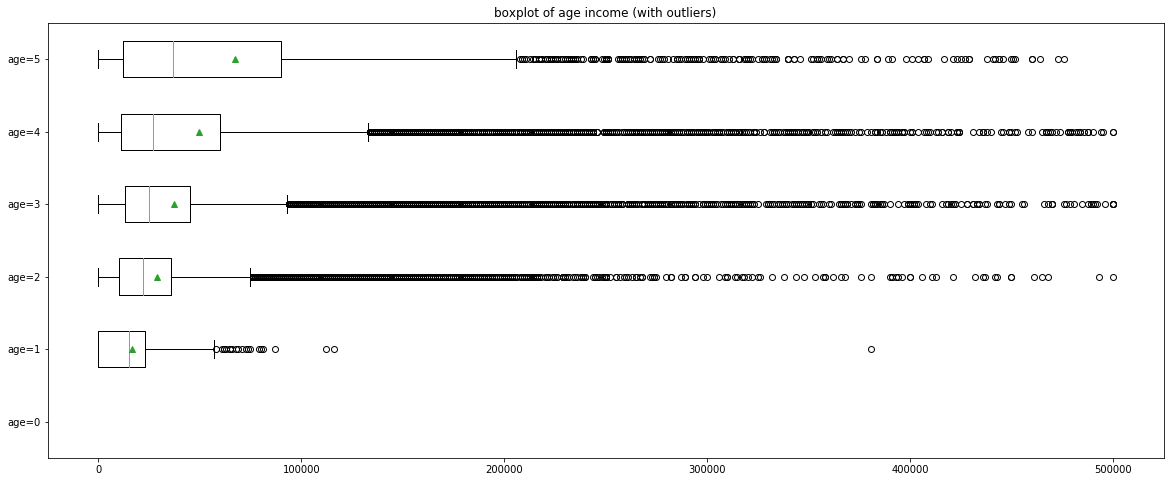

In [374]:
fig5, ax5 = plt.subplots(figsize=(20, 8))
ax5.set_title('boxplot of age income (with outliers)')
_ = plt.boxplot(inc_by_age,vert=False,showfliers=True,showmeans=True,labels=['age={}'.format(i) for i in range(6)])

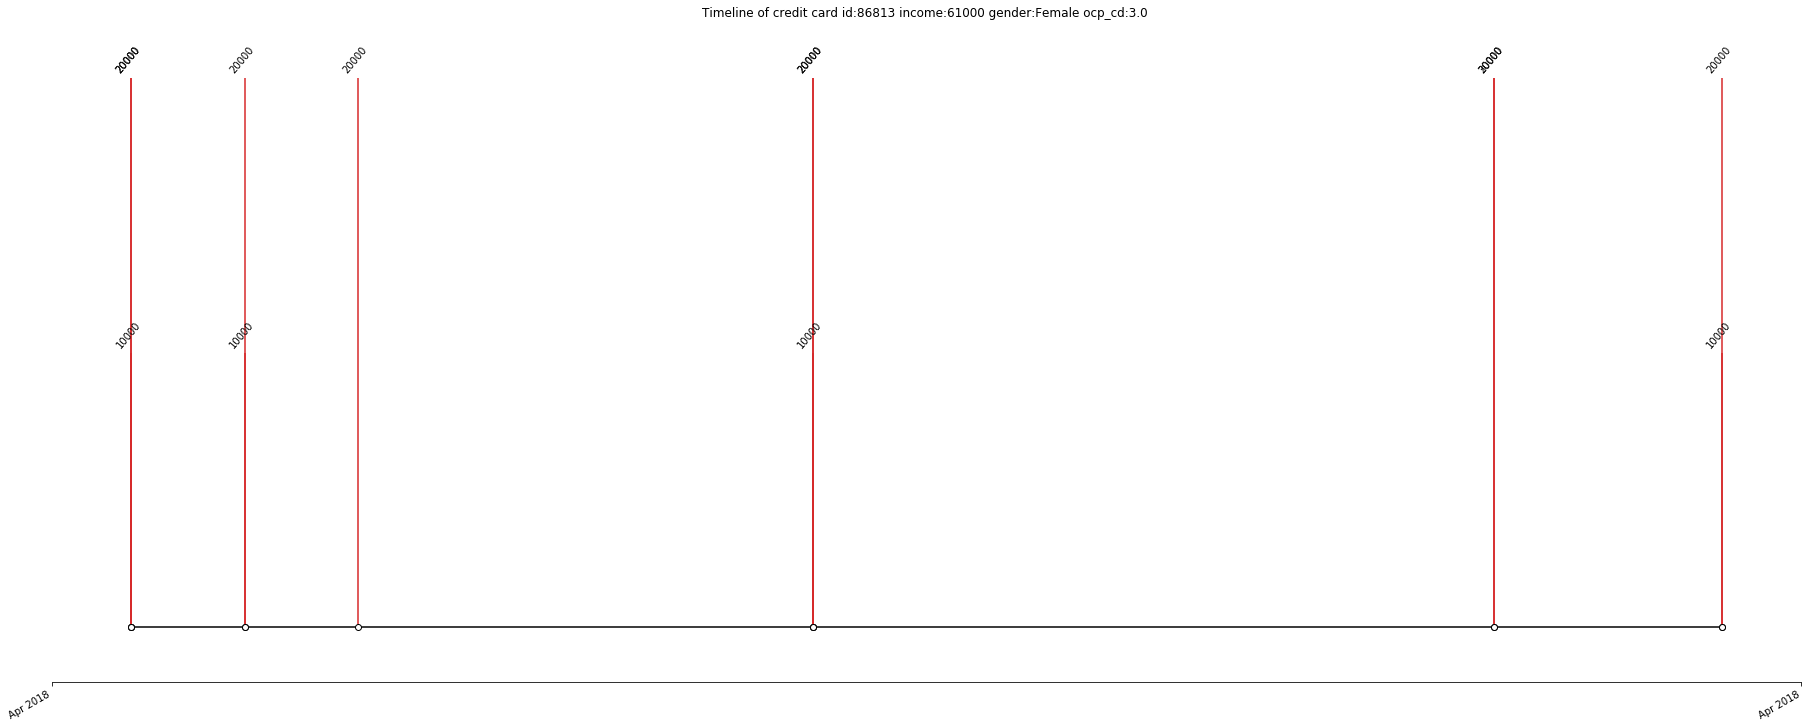

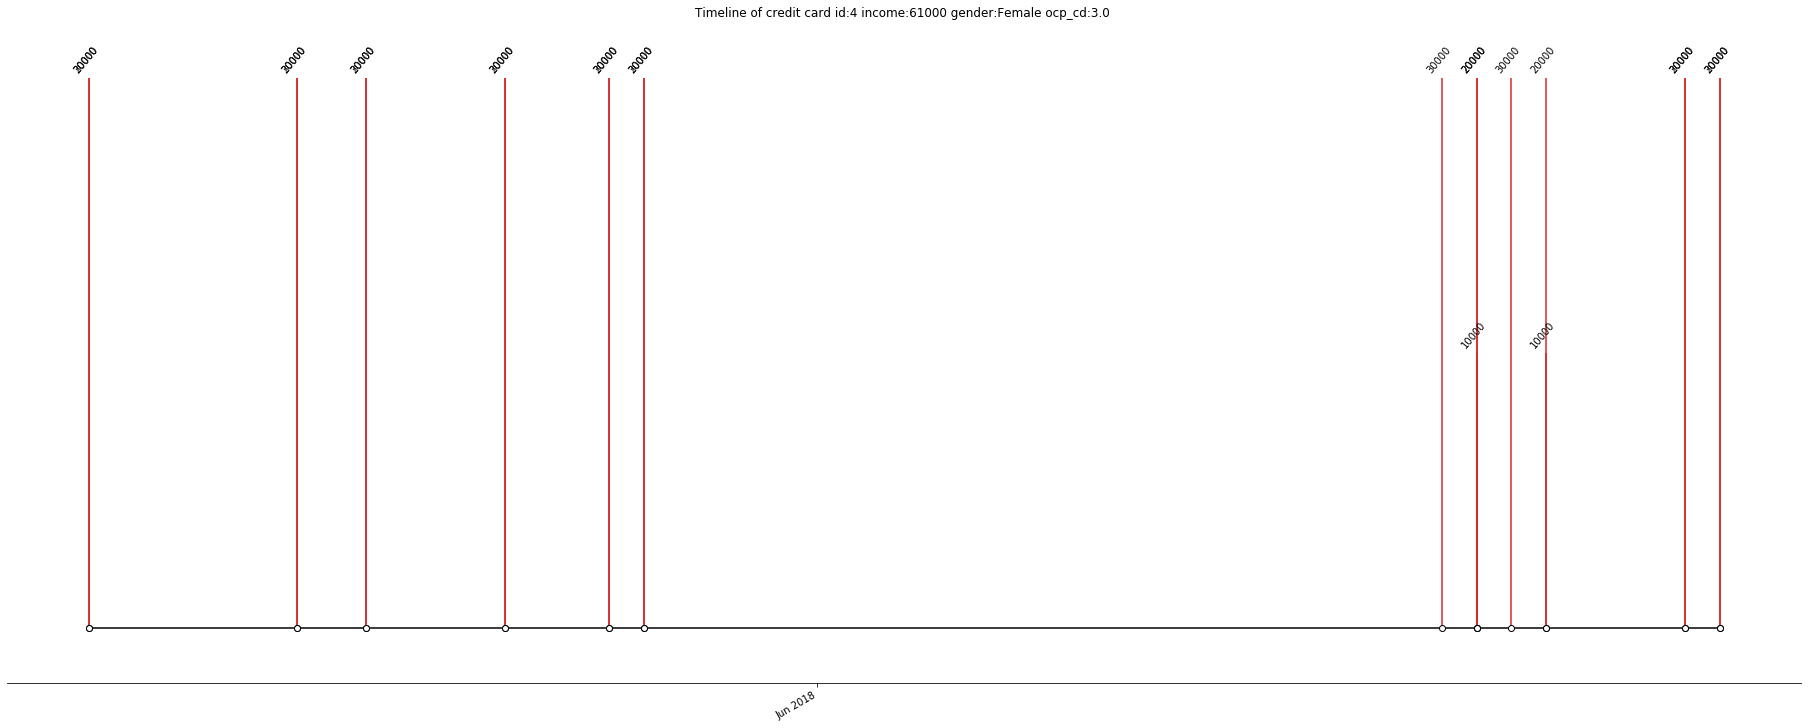

(None, None)

In [379]:
show_timeline(86813), show_timeline(4)

In [376]:
info_by_id[4]

{'cc_no': {4.0, 86813.0},
 'gender': 2.0,
 'ocp_cd': 3.0,
 'age': 5.0,
 'isTrain': True,
 'income': 61000,
 'sunday': ['2018-04-29',
  '2018-03-04',
  '2018-04-15',
  '2018-02-11',
  '2018-06-24',
  '2018-04-08',
  '2018-01-07',
  '2018-03-11',
  '2018-06-03',
  '2018-06-10',
  '2018-06-17',
  '2018-04-22',
  '2018-03-18',
  '2018-04-01',
  '2018-02-04',
  '2018-05-27',
  '2018-01-14',
  '2018-05-06',
  '2018-03-25',
  '2018-01-28',
  '2018-02-18',
  '2018-02-25',
  '2018-05-20',
  '2018-01-21',
  '2018-05-13'],
 'kp_txn_count': [17,
  11,
  4,
  18,
  14,
  13,
  10,
  14,
  11,
  20,
  9,
  9,
  15,
  11,
  12,
  9,
  6,
  18,
  8,
  15,
  11,
  19,
  16,
  16,
  9],
 'kp_txn_amt': [217700,
  198000,
  76500,
  207400,
  394800,
  188100,
  364600,
  140400,
  290400,
  500200,
  225200,
  678400,
  165800,
  144800,
  132400,
  52400,
  104500,
  430300,
  211100,
  164000,
  230600,
  288600,
  158400,
  423600,
  87900]}

In [10]:
_score = None
_val = None
def SMAPE(y_true, y_pred):
    global _score, _val
    #initate tf variables
    if _score is None:
        _score = tf.Variable(100.0, dtype=tf.float32)
    if _val is None:
        _val = tf.Variable(0.0, dtype=tf.float32)
        
    N = tf.cast(tf.shape(y_true, out_type=tf.int32)[0], dtype=tf.float32)
    
    t1 = tf.math.pow(tf.abs(tf.math.subtract(y_pred, y_true)), tf.constant(2.0, dtype=tf.float32))
    t2 = tf.math.minimum( tf.math.multiply(tf.constant(2.0, dtype=tf.float32),y_true), y_pred)
    t3 = tf.math.pow(tf.add(t2, tf.math.abs(y_true)), tf.constant(2.0, dtype=tf.float32))
    t4 = tf.math.divide(t1, t3)
    m = tf.multiply(tf.divide(tf.constant(100.0,dtype=tf.float32), N), t4)
    res = tf.math.subtract(_score, m)
    return res

### Age,Gender,Occupation -> income

In [41]:
#use training data to self evaluate using ratio 0.9 to 0.1
x_train, x_test, y_train, y_test = [], [], [], []
bound = int(0.8 * len(data['train']))
for i in range(len(data['train'])):
    _id, inc = data['train'].iloc[i]
    age = info_by_id[_id]['age']
    gender = info_by_id[_id]['gender']
    ocp = info_by_id[_id]['ocp_cd']
    
    if np.isnan(ocp):
        ocp = -1 #indicate that ocp is not available    
    if np.isnan(age) or np.isnan(gender):
        raise ValueError('isnan on age/gender') #should not raise any error
    
    if i < bound:
        x_train.append([age, gender, ocp])
        y_train.append(inc)
    else:
        x_test.append([age, gender, ocp])
        y_test.append(inc)
x_train, x_test, y_train, y_test = np.asarray(x_train, dtype=np.float32), np.asarray(x_test, dtype=np.float32), np.asarray(y_train, dtype=np.float32), np.array(y_test, dtype=np.float32)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((40000, 3), (10000, 3), (40000,), (10000,))

In [52]:
adam = Adam(lr=1e-3,amsgrad=True)
model = Sequential()
model.add(Dense(200, activation='relu', input_shape=(3,), kernel_regularizer=tf.keras.regularizers.l2(0.01), activity_regularizer=tf.keras.regularizers.l1(0.01)))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(200, activation='relu'))
model.add(BatchNormalization())
model.add(Dense(1, activation='relu'))
model.compile(loss='mse', optimizer=adam, metrics=[SMAPE])
model.build()
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 200)               800       
_________________________________________________________________
batch_normalization_14 (Batc (None, 200)               800       
_________________________________________________________________
dense_20 (Dense)             (None, 200)               40200     
_________________________________________________________________
batch_normalization_15 (Batc (None, 200)               800       
_________________________________________________________________
dense_21 (Dense)             (None, 200)               40200     
_________________________________________________________________
batch_normalization_16 (Batc (None, 200)               800       
_________________________________________________________________
dense_22 (Dense)             (None, 200)              

In [ ]:
hist = model.fit(x=x_train,y=y_train, epochs=30, batch_size=32,validation_data=(x_test, y_test), verbose=1)

Train on 40000 samples, validate on 10000 samples
Epoch 1/30
40000/40000 [==============================] - 4s 96us/sample - loss: 5149851939.2768 - SMAPE: 96.9802 - val_loss: 4839175291.9040 - val_SMAPE: 97.1258
Epoch 2/30
40000/40000 [==============================] - 3s 71us/sample - loss: 4984274492.9280 - SMAPE: 97.4199 - val_loss: 4722804443.7504 - val_SMAPE: 97.3972
Epoch 3/30
40000/40000 [==============================] - 3s 70us/sample - loss: 4714667659.4688 - SMAPE: 97.9569 - val_loss: 4239685922.2016 - val_SMAPE: 98.3219
Epoch 4/30
40000/40000 [==============================] - 3s 71us/sample - loss: 4392259557.2224 - SMAPE: 98.3876 - val_loss: 4048656752.4352 - val_SMAPE: 98.4842
Epoch 5/30
40000/40000 [==============================] - 3s 70us/sample - loss: 4054644858.6752 - SMAPE: 98.7275 - val_loss: 3588157602.9184 - val_SMAPE: 98.9506
Epoch 6/30
12832/40000 [========>.....................] - ETA: 1s - loss: 3949507618.7930 - SMAPE: 98.9348

In [49]:
loss,val_loss, score,val_score = hist.history['loss'],hist.history['val_loss'], hist.history['SMAPE'], hist.history['val_SMAPE']

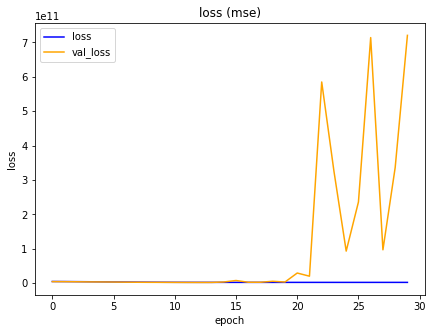

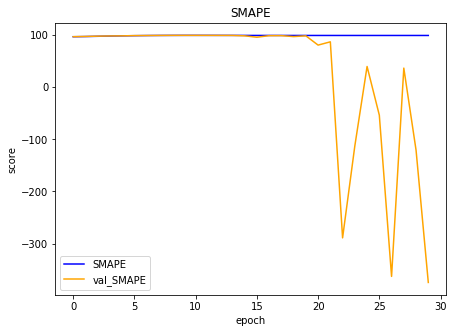

In [50]:
plt.figure(figsize=(7,5))
plt.title('loss (mse)')
plt.plot(np.arange(len(loss)),loss,label='loss',color='blue')
plt.plot(np.arange(len(val_loss)),val_loss,label='val_loss',color='orange')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.figure(figsize=(7,5))
plt.title('SMAPE')
plt.plot(np.arange(len(score)),score,label='SMAPE',color='blue')
plt.plot(np.arange(len(val_score)),val_score,label='val_SMAPE',color='orange')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend()
plt.show()